# 3D Poses

In [1]:
#|default_exp pose

In [5]:
#|export
import jax
import jax.numpy as jnp
import genjax
from   genjax.generative_functions.distributions import ExactDensity
from dataclasses import dataclass
from collections import namedtuple
from plum import dispatch

PI    = jnp.pi
TWOPI = 2*PI

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
key = jax.random.PRNGKey(0)
jax.__version__

'0.4.14'

## 2D Pose

In [8]:
#|export
def rot2d(hd): return jnp.array([
    [jnp.cos(hd), -jnp.sin(hd)], 
    [jnp.sin(hd),  jnp.cos(hd)]
    ]);

def pack_2dpose(x,hd): 
    return jnp.concatenate([x,jnp.array([hd])])

def apply_2dpose(p, ys): 
    return ys@rot2d(p[2] - jnp.pi/2).T + p[:2]

def unit_vec(hd): 
    return jnp.array([jnp.cos(hd), jnp.sin(hd)])

def adjust_angle(hd): 
    return (hd + jnp.pi)%(2*jnp.pi) - jnp.pi

## JAX Rotations

Unfortunately we are using JAX `v0.4.7` but `scipy.spatial.transform.Rotation` was added in `v0.4.12`.

So we have to define some helpers ourselves.

```
World coordinates
           
      z     
      |  y  . . . . . . .
      | /  .  Ground   .    
      |/  . . . . . . .
      * - - - - - - - x   

```


```
Camera coordinates

        z
       /
      * - - - - - - - x
      | . . . . . . .         
      | .   Image   .
      | . . . . . . .           
      y  
      
```

```
Meshplot Viewer coords 
(rotates in xz-plane, pitch in yz-plane)

      y . . . . . .
      | . screen  .     
      | . . . . . .
      * - - - - x   
     /
   z  
   
```

```
      z           
      |  y        
      | /      
      |/       
      * - - - - - - - x  
``` 

In [14]:
#|export
CAM_ALONG_X = jnp.array([
    [0,  0, 1],
    [-1, 0, 0],
    [0,  -1, 0]
])


def rot_x(theta):
    return jnp.array([
        [1, 0, 0],
        [0, jnp.cos(theta), -jnp.sin(theta)],
        [0, jnp.sin(theta), jnp.cos(theta)]
    ])


def rot_y(theta):
    return jnp.array([
        [jnp.cos(theta), 0, -jnp.sin(theta)],
        [0, 1, 0],
        [jnp.sin(theta), 0, jnp.cos(theta)]
    ])


def rot_z(theta):
    return jnp.array([
        [jnp.cos(theta), -jnp.sin(theta), 0],
        [jnp.sin(theta), jnp.cos(theta), 0],
        [0, 0, 1]
    ])


def from_euler(rot, pitch=0.0, roll=0.0):
    """
    Imagine you stand on xy-plane and rotate (z-axis), pitch (y'-axis), and roll (x''-axis).
    """
    return rot_z(rot)@rot_y(pitch)@rot_x(roll)


def look_at(v, roll=0.0, cam=True):
    """Imagine you stand on xy-plane and point a camera at a point v in 3d space."""
    R = CAM_ALONG_X if cam else jnp.eye(3)

    n = jnp.linalg.norm(v)
    rot   = jnp.arctan2(v[1],v[0])
    pitch = jnp.arctan2(v[2],n)
    return from_euler(rot, pitch, roll)@R

In [13]:
#|export
def ax_to_ind(c):
    lookup = {"x":0, "y":1, "z":2}
    return lookup[c]


class Rotation(object):
    @staticmethod
    def _x(theta):
        return jnp.array([
            [1, 0, 0],
            [0, jnp.cos(theta), -jnp.sin(theta)],
            [0, jnp.sin(theta), jnp.cos(theta)]
        ])

    @staticmethod
    def _y(theta):
        return jnp.array([
            [jnp.cos(theta), 0, -jnp.sin(theta)],
            [0, 1, 0],
            [jnp.sin(theta), 0, jnp.cos(theta)]
        ])

    @staticmethod
    def _z(theta):
        return jnp.array([
            [jnp.cos(theta), -jnp.sin(theta), 0],
            [jnp.sin(theta), jnp.cos(theta), 0],
            [0, 0, 1]
        ])

    @staticmethod
    def _ax(ax:str, theta):
        if   ax == "x": return Rotation._x(theta)
        elif ax == "y": return Rotation._y(theta)
        elif ax == "z": return Rotation._z(theta)
        
    @staticmethod
    def from_euler(order, angles):
        """
        Args:
            order  : String of length 3, e.g. "xyz"
            angles : Array of length 3, e.g. [0, 0, 0]
        """
        rot_ax = Rotation._ax
        return rot_ax(order[0], angles[0])@rot_ax(order[1],angles[1])@rot_ax(order[2],angles[2])
    
    @staticmethod
    def look_at(v, roll=0.0, order="zyx"):
        """
        """
        n = jnp.linalg.norm(v)
        rot   = jnp.arctan2(v[1],v[0])
        pitch = jnp.arctan2(v[2],n)
        return Rotation.from_euler(order, [rot, pitch, roll])@yzX[:3,:3]
    
Rot = Rotation


In [12]:
(
    jnp.linalg.det(rot_x(0.0)), 
    jnp.linalg.det(rot_y(0.0)), 
    jnp.linalg.det(rot_z(0.0)) 
)

(Array(1., dtype=float32), Array(1., dtype=float32), Array(1., dtype=float32))

## Poses Utils

In [8]:
#|export
Pose    = namedtuple("Pose", ["x", "r"])

@dispatch
def unpack_pose(p:Pose): 
    return p.x, p.r

@dispatch
def unpack_pose(R:jnp.ndarray): 
    return R[:3,3], R[:3,:3]

def pack_pose(x, r): 
    return jnp.concatenate([
        jnp.concatenate([r, x[:,None]], axis=1), 
        jnp.array([[0,0,0,1]])], axis=0)

def apply_pose(p, x):
    t, r = unpack_pose(p)
    return x@r.T + t

In [15]:
#|export
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def mpl_plot_pose(ax, p, s=0.1, length=0.1, normalize=True, **kwargs):

    t,r = unpack_pose(p)
    # Coordinate frame data
    origin = t
    x_axis = s*r[:3,0]
    y_axis = s*r[:3,1]
    z_axis = s*r[:3,2]

    # Plotting the coordinate frame
    ax.quiver(*origin, *x_axis, color='r', label='X-axis', length=length, normalize=normalize, **kwargs)
    ax.quiver(*origin, *y_axis, color='g', label='Y-axis', length=length, normalize=normalize, **kwargs)
    ax.quiver(*origin, *z_axis, color='b', label='Z-axis', length=length, normalize=normalize, **kwargs)

In [16]:
#|hide
ps = jax.random.uniform(key, (100,4,4))
ps = ps.at[0].set(jnp.eye(4))

xs = jax.random.uniform(key, (100,3))

ys = jax.vmap(apply_pose)(ps, xs)
print(ys.shape, jnp.all(ys[0] == xs[0]))

ys = jax.vmap(apply_pose, (0,None))(ps, xs)
print(ys.shape, jnp.all(ys[0] == xs))

(100, 3) True
(100, 100, 3) True


In [36]:
#|export
def lift_pose(x, hd, z=0.0, pitch=0.0, roll=0.0):
    """Lifts a 2d pose (x,hd) to 3d"""
    return pack_pose(
        jnp.concatenate([x, jnp.array([z])]),
        from_euler(hd) @ CAM_ALONG_X
    ) 

In [ ]:
# def lift_pose(v, z=0.0, pitch=0.0, roll=0.0):
#     """Lifts a 2d pose (x,hd) to 3d"""
#     x  = v[:2]
#     hd = v[2]
#     return pack_pose(
#         jnp.concatenate([x, jnp.array([z])]),
#         from_euler(hd) @ CAM_ALONG_X
#     ) 

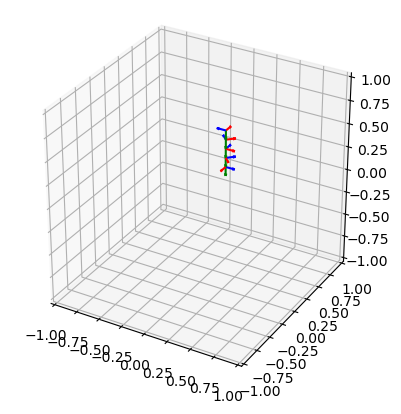

In [37]:
ps = [
    lift_pose(jnp.array([0.0,0.5]), 0.0, z=0.0),
    lift_pose(jnp.array([0.0,0.5]), jnp.pi/4, z=.1),
    lift_pose(jnp.array([0.0,0.5]), jnp.pi/2, z=.2),
    lift_pose(jnp.array([0.0,0.5]), 3*jnp.pi/4, z=.3),
    lift_pose(jnp.array([0.0,0.5]), jnp.pi, z=0.4)
]

# -----------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
for p in ps:
    mpl_plot_pose(ax, p, s=.1, length=.1)
fig.show();

In [11]:
#|hide
xs  = jax.random.normal(key, (100,2))
hds = jnp.pi*2*jax.random.normal(key, (100,))

ps = jax.vmap(lift_pose, (0,0,None))(xs, hds, 1.0)
ps.shape


(100, 4, 4)

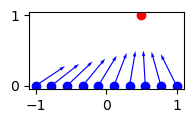

In [11]:
n = 10
xs  = jnp.stack([jnp.linspace(-1,1,n),jnp.zeros(n)], axis=1)
y   = jnp.array([0.5,1.0])
hds = jnp.arctan2(y[1] - xs[:,1], y[0] - xs[:,0])

# -----------------
plt.figure(figsize=(2,2))
plt.gca().set_aspect("equal")
plt.scatter(*xs.T, marker="o", c="b")
plt.quiver(xs[:,0],xs[:,1], jnp.cos(hds), jnp.sin(hds), color='b', label='X-axis', scale=2., units="xy")
plt.scatter(*y, c="r");

In [13]:

y_  = jnp.concatenate([y, jnp.array([0.5])])
xs_ = jnp.concatenate([xs, jnp.zeros((n,1))], axis=1)

[0.5 1.  0.5]


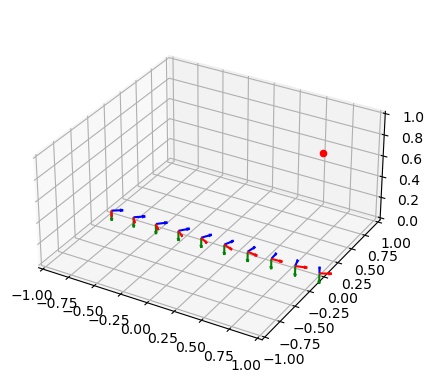

In [14]:
ps = jax.vmap(lift_pose)(xs, hds)

print(y_)
# -----------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,0.5))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-0,1)
ax.scatter(*y_, c="red")
for p in ps:
    mpl_plot_pose(ax, p, s=.1, length=.1)
fig.show();

(10, 4, 4)


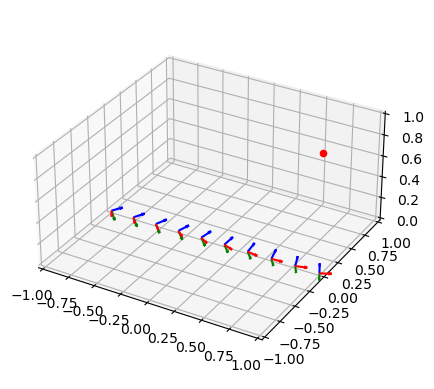

In [16]:
ps = jax.vmap(
    lambda x,y: pack_pose(x, look_at(y-x)), 
    (0,None)
    ) (xs_, y_)

print(ps.shape)
# -----------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,0.5))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-0,1)
ax.scatter(*y_, c="red")
for p in ps:
    mpl_plot_pose(ax, p, s=.1, length=.1)
fig.show();